In [183]:
import math
import matplotlib.pyplot as plt
import numpy as np
import nltk
import os
import pandas as pd

from scipy.stats import pearsonr
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import mean_squared_error

In [2]:
TRAIN_DATA = '/datasets/sts-train.csv'
TEST_DATA = '/datasets/sts-test.csv'
CWD = os.getcwd()

In [3]:
def create_dataframe(data_dir=TRAIN_DATA):
    sentences = {'similarity': [], 'S1': [], 'S2': []}

    for line in open('{0}/{1}'.format(CWD, data_dir), 'r'):
        line = line.split('\t')

        if len(line) == 7:
            sentences['similarity'].append(float(line[-3]))
            sentences['S1'].append(line[-2])
            sentences['S2'].append(line[-1])
        else:
            sentences['similarity'].append(float(line[-5]))
            sentences['S1'].append(line[-4])
            sentences['S2'].append(line[-3])
    
    df = pd.DataFrame.from_dict(sentences)
    print ('num rows in df {0}\n'.format(len(df)))
    print (df.head())
    
    return df

In [165]:
train_df = pd.concat([create_dataframe(), create_dataframe(TEST_DATA)])

num rows in df 5749

   similarity                                             S1  \
0        5.00                         A plane is taking off.   
1        3.80                A man is playing a large flute.   
2        3.80  A man is spreading shreded cheese on a pizza.   
3        2.60                   Three men are playing chess.   
4        4.25                    A man is playing the cello.   

                                                  S2  
0                      An air plane is taking off.\n  
1                        A man is playing a flute.\n  
2  A man is spreading shredded cheese on an uncoo...  
3                       Two men are playing chess.\n  
4               A man seated is playing the cello.\n  
num rows in df 1379

   similarity                                             S1  \
0         2.5                    A girl is styling her hair.   
1         3.6       A group of men play soccer on the beach.   
2         5.0  One woman is measuring another woman

In [166]:
len(train_df)

7128

In [6]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
    return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [11]:
# embeddings produce a 512-length vector representing the sentence context
sample = train_df['S1'][0]
print (sample)
message_embeddings = embed([sample])
print (message_embeddings.shape)

A plane is taking off.
(1, 512)


### Qualitatively Evaluate Embeddings on a Small Sample by Plotting a Heatmap

In [52]:
# given sentence pairs that have been evaluated together create a heatmap
# features = sentence embeddings, labels = sentences
# first half corresponds to second half
def plot_similarity(labels, features, rotation):
    M = int(len(features) / 2)
    text_cutoff = 50
    
    labels = [label[:text_cutoff] for label in labels]
    corr = np.inner(features[:M], features[M:])
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels[:M],
      yticklabels=labels[M:],
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels[:M], rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    g.get_figure().savefig("./sonia-mannan-sentence-embeddings-results/sample_heatmap.png", bbox_inches='tight')

def run_and_plot(messages_):
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 90)

S(A plane is taking off., An air plane is taking off.
) = 5.0
S(A man is playing a large flute., A man is playing a flute.
) = 3.8
S(A man is spreading shreded cheese on a pizza., A man is spreading shredded cheese on an uncooked pizza.
) = 3.8
S(Three men are playing chess., Two men are playing chess.
) = 2.6
S(A man is playing the cello., A man seated is playing the cello.
) = 4.25


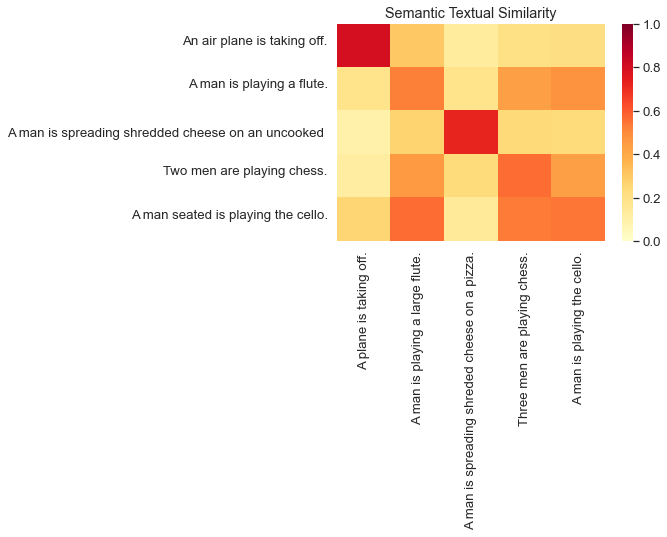

In [51]:
messages = list(train_df['S1'][:5]) + list(train_df['S2'][:5])
similarities = train_df['similarity'][:5]
for i in range(len(similarities)):
    print ('S({0}, {1}) = {2}'.format(train_df['S1'][i], train_df['S2'][i], similarities[i]))
run_and_plot(messages)

### Quantitively Evaluate Embeddings by Calculating Cosine Similarities

In [101]:
def magnitude(e1):
    return np.sqrt(np.sum(np.square(e1)))

In [102]:
def cosine_similarity(e1, e2):
    return (np.dot(e1, e2) / (magnitude(e1) * magnitude(e2)))

In [172]:
assert train_df['similarity'].shape[0] == train_df['S2'].shape[0] == train_df['S1'].shape[0]

# get embeddings for each sentence pair, 5,749 x 512
e1 = tf.nn.l2_normalize(embed(train_df['S1']), axis=1)
e2 = tf.nn.l2_normalize(embed(train_df['S2']), axis=1)

# take the cosine similarity between each embedding
calculated_similarities = np.array([cosine_similarity(x, y) for x, y in zip(e1, e2)])
actual_scores = train_df['similarity']

# calculate the pearson correlation
pearson_correlation = pearsonr(calculated_similarities, actual_scores)

### Pearson correlation measures similarity between two variables
#### -1 = opposite, 0 = neatral, 1 = same -> higher score means they are more similar
#### We expect the correlation between calculated and real scores to be high

In [173]:
print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

Pearson correlation coefficient = 0.6786418342212369
p-value = 0.0


#### We can also calculate the RMSE between calculated and real scores by interpolating calculated scores between 0-5
#### Perfect RMSE = 0
#### Random RMSE = 2.1492 -> randomly generate an array of 0-5
#### Actual RMSE = 1.167 -> not perfect but better than randomly guessing

In [191]:
calculated_scores = np.interp(calculated_similarities, (calculated_similarities.min(), \
                                                        calculated_similarities.max()), (0, +5))
print ('Actual RMSE', mean_squared_error(actual_scores, calculated_scores, squared=False))

Actual RMSE 1.167451351776908


In [192]:
print ('Perfect RMSE', mean_squared_error(actual_scores, actual_scores, squared=False))

Perfect RMSE 0.0


In [193]:
print ('Random RMSE', mean_squared_error(actual_scores, np.random.randint(5, size=len(actual_scores)), squared=False))

Random RMSE 2.175803240562318
